1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

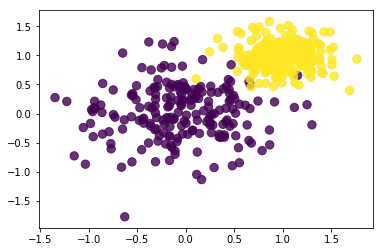

In [11]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


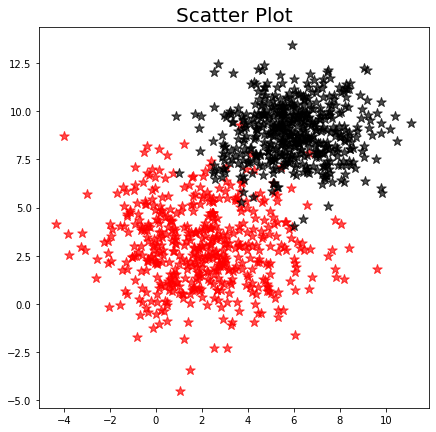

In [26]:
def generator(meanList, covList, N):
  data1 = generate_data(meanList[0], covList[0], N)
  data2 = generate_data(meanList[1], covList[1], N)
  return generate_df(data1), generate_df(data2)

def generate_data(mean, cov, N):
    return np.random.multivariate_normal(mean, cov, N)

def generate_df(data):
    return pd.DataFrame(data, columns = ["x", "y"])

mean = ([2, 3], [6, 9])
covariance = ([[-5, 0], [0, 5]], [[-3, 0], [0, 2]])
N = 500

df1, df2 = generator(mean, covariance, N)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.set_title("Scatter Plot",  fontsize = 20)
ax.scatter(x = "x", y = "y", data = df1, marker = "*", c = "red", s=100, alpha = 0.7)
ax.scatter(x = "x", y = "y", data = df2, marker = "*", c = "black", s=100, alpha = 0.7)
plt.show()

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [28]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

--2021-12-07 14:42:25--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2021-12-07 14:42:25--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4fe13480757e9d2e692b65fc74.dl.dropboxusercontent.com/cd/0/inline/BbZWSzcaMC73vyt8F5RmmmTS-nVaNSTnkU3SYJEtHVIfH6roq33JIFiZnMysJts4vgdMVBvJ7G9xjw28X0u73918HI5ZV1D7aJHmGGJZwOxoKfyr5YHu0Fx_jhSGQ_33CkdGpTkJHunVFwzdr4GtzY3y/file# [following]
--2021-12-07 14:42:25--  https://uc4fe13480757e9d2e692b65fc74.dl.dropboxusercontent.com/cd/0/inline/BbZWSzcaMC73vyt8F5RmmmTS-nVaNSTnkU3SYJEtHVIfH6roq33JIFiZnMysJts4vgdMVBvJ7G

In [43]:
import pandas as pd

data = pd.read_pickle('data/residuals_261.pkl')
data

data_dictionary = data[()]

df=pd.DataFrame(data_dictionary)
df


,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


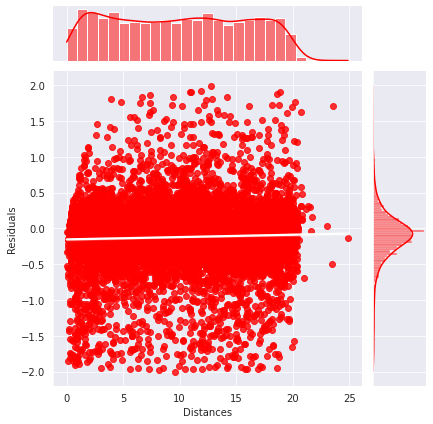

In [57]:
# Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
df_clean = df[df['residuals'].abs() < 2]


# Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 
import seaborn as sns


plot = sns.jointplot(x="distances", y="residuals", data=df_clean, kind="reg", color = "r" ,line_kws = {"color": "w"});
plot.set_axis_labels("Distances", "Residuals")


3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


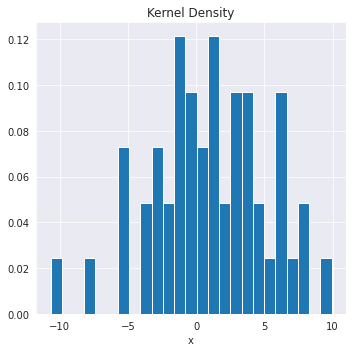

In [90]:
import matplotlib.pyplot as plt

arr = np.random.normal(scale = 10, size = 100)
arr

fig, ax = plt.subplots(figsize=(5, 5))
y, bins, patches = plt.hist(x, bins=25, density=True)

ax.set_title('Kernel Density')
ax.set_xlabel('x')

centers = 0.5 * (bins[:-1] + bins[1:])

fig.tight_layout()

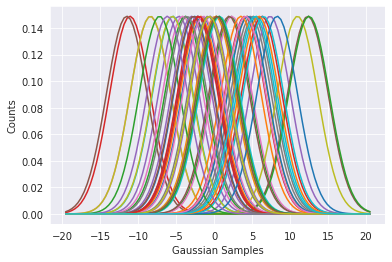

In [93]:
from scipy.stats import norm

loc=0
std_dev=5
size=50
x = np.random.normal(loc=loc, scale=std_dev, size=size)
mean = x
std_dev=1.06*np.std(x)*len(x)**(-1/5)
x_points = np.linspace(np.min(mean) - 3*std_dev, np.max(mean) + 3*std_dev, 100)
y_points= np.array([norm.pdf(x_points, mean[i], std_dev) for i in range(len(x)) ])
for i in y_points: plt.plot(x_points, i)
plt.xlabel('Gaussian Samples')
plt.ylabel('Counts')

plt.show()